In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))

In [2]:

sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
kb = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

from misloc_package.parameterize import displaced_osc_model as dom


Plot parameters

In [3]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 300,  # to adjust notebook inline plot size
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


Load data 

In [57]:
path_to_mol_data = os.path.join('..', 'data')

emily_data_flip = np.loadtxt(
    os.path.join(path_to_mol_data, 'H-1-slow-pf.csv'), 
#     skiprows=0, 
    delimiter=','
    )
emily_data = emily_data_flip[::-1]

## Some useful functions
def norm_spec(spec):
    return spec/spec.max()

# def nm_to_ev_correct(spec):
#     return spec/(1240/thermo_fisher_dye_data.T[0])**5.

In [60]:
emily_data

array([[2.09284, 0.86606],
       [2.09376, 0.86531],
       [2.09468, 0.79653],
       ...,
       [2.88031, 0.01111],
       [2.88205, 0.00925],
       [2.88378, 0.00746]])

In [48]:
def int_norm(y, x=emily_data.T[0]):
    return y / int.trapz(y, x)

In [75]:
def model_from_params(
    params, 
    num_modes, 
    temp
    ):
    return dom.anda_mol_fluo_model(
        num_vib_modes=num_modes,
        hbar_omega_eg_0=float(params[0]),
        script_d=params[2+1*num_modes: 2+2*num_modes],
        hbar_omega_0=params[2: 2+1*num_modes],
        hbar_gamma=[params[1]]*num_modes,
        T=temp)

def muk_mol_fit_fun(params, *args):
    """ Try naive fit function with fixed integration differential size
        and bound.

        Params: (list of fit parameters) Should be list of 
            2 + (3*num_modes) containing the following model parameters;
            ~~~~~~~~~~~~~~~~
            [0] hbar_omega_eg_0: the difference in zero point energy of 
                the vibrational oscillators between the two electronic
                states (eV).
                
            [1] hbar_gamma: damping rate from 
                solvent or etc.
            
            [2:2+num_modes] hbar_omega_0: vibrational ressonance energy 
                in eV.
                
            [2+num_modes:2+2*num_modes] script_d: unitless 
                displacement of the vibronic potential surface between
                electronic states.

        Args: (list of x axis and data)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            hbar_omega:
            data:
            num_modes:
        """
    [
        hbar_omegas, 
        data, 
        num_modes, 
        t_bound, 
        t_points, 
        norm,
        temp
        ] = args

    model_instance = model_from_params(params, num_modes, temp=temp)
    
    model = model_instance.emission_lineshape(
        hbar_omegas/hbar,
        t_bound=t_bound,
        t_points=t_points,
        )

    if (norm is 'integral') or (norm is 'Integral') or (norm is 'int'):
        ## Normalize model and data
        model = int_norm(model, hbar_omegas)
    elif norm is 'magnitude':
        ## Normalize model and data
        model = model / np.max(model)
        data = data / np.max(data)

    return (model - data) * model 

In [128]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.6
ini_script_d = [1.75, 2.5]
ini_hbar_omega_0 = [0.132, .018]
ini_hbar_gamma = .013
T = 294

## Bounds on fit parameters
bounds_hbar_omega_eg_0 = [2.58, 3]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0.12, 0.01], [np.inf, 0.1]]
bounds_hbar_gamma = [0.001, np.inf]


## New 06/02
## Sort initial guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])
## Define arguments for fit routine
## (Might have to change these)

hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 250
t_points_arg = 1000
norm_arg = 'integral'

## Arrange fit arguments
## (Don't change)
fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    T
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_hbar_gamma
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_script_d

In [104]:
model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds,
    x_scale=[1, .01, .1, .01, 1, 1]
    )

KeyboardInterrupt: 

Plot fit result

Text(0, 0.5, 'Normalized Emission Probability')

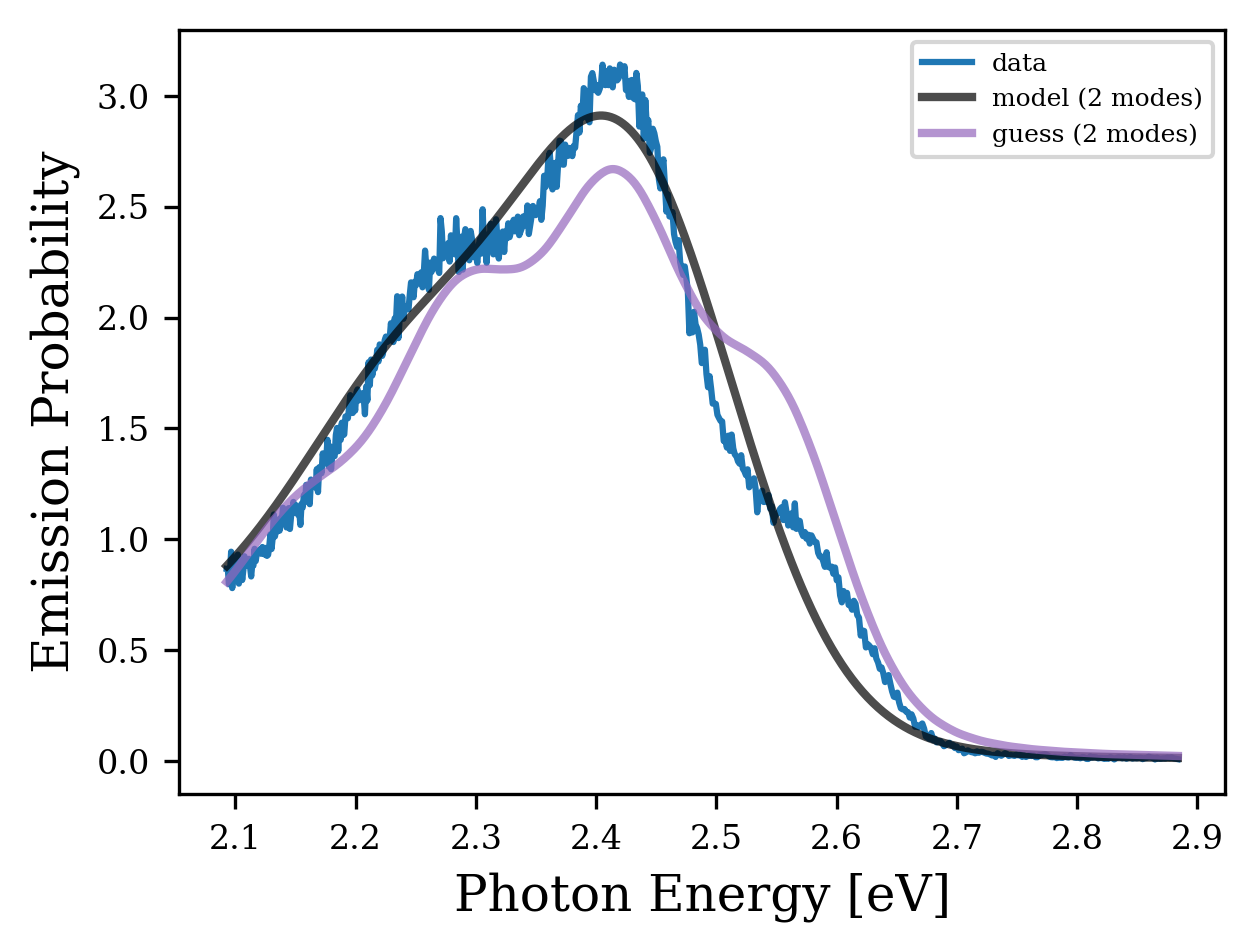

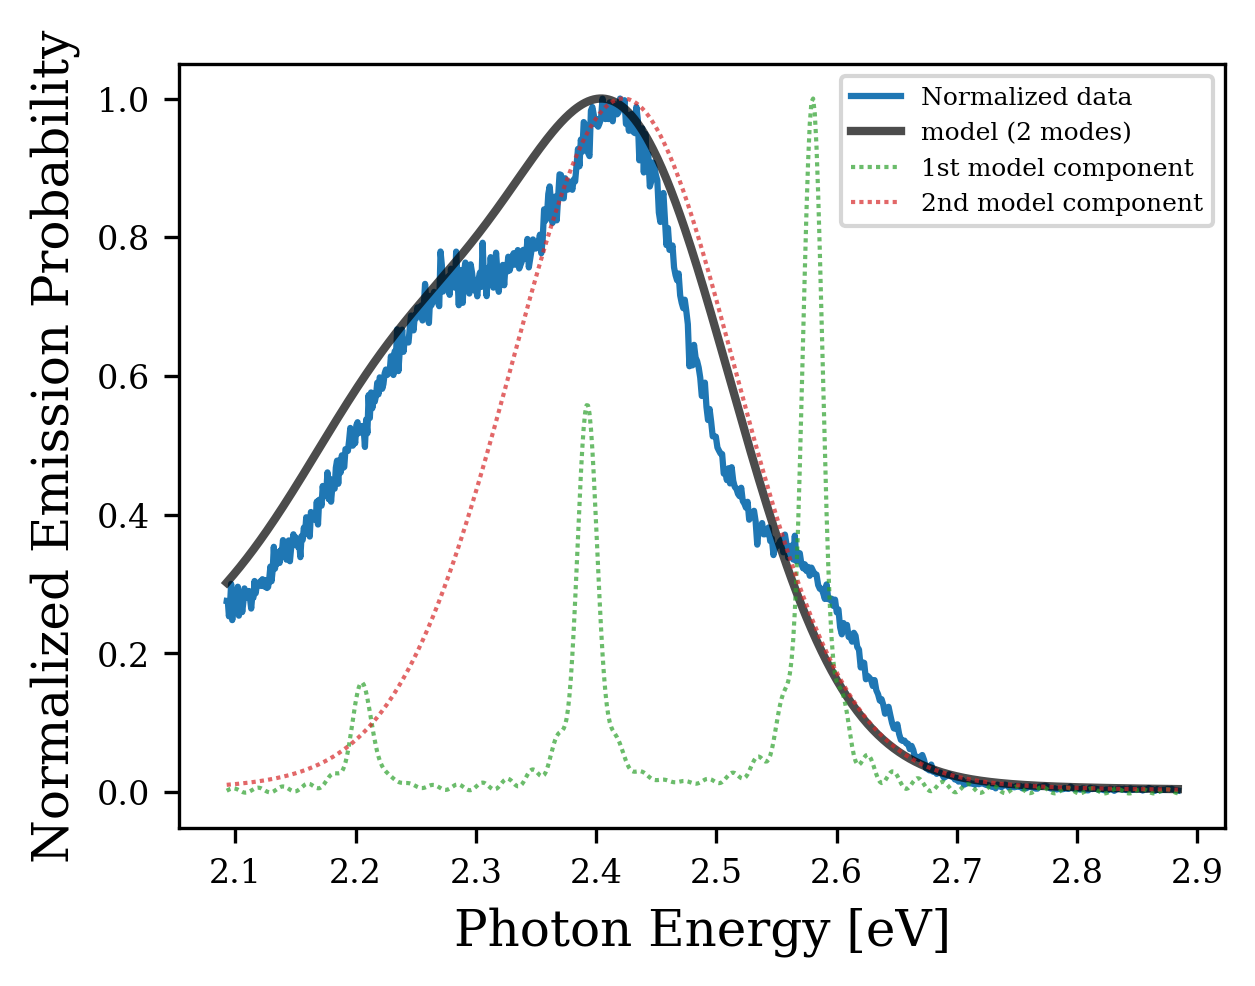

In [129]:
## Build model fit from fit parameters
model_fit_inst = model_from_params(model_fit['x'], num_modes=2, temp=T)
ini_guess_inst = model_from_params(fit_ini_guess, num_modes=2, temp=T)

## Get model lineshape
model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 200,
    t_points = 1000)
## ini. guess lineshape
ini_2_mode = ini_guess_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 200,
    t_points = 1000)

##
model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 200,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 200,
    t_points = 1000)


## Build first plot
plt.figure()

## Plot data and model fit
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], int_norm(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], int_norm(ini_2_mode), ls='-', lw=2, c='C4', alpha=0.7, label='guess (2 modes)')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Emission Probability')

## second figure with components
plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


In [85]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

In [86]:
print_parameters_w_names(model_fit['x'])

hbar_omega_eg_0 = 2.5800000000000005
hbar_gamma = 0.010276335192987525
hbar_omega_0 = [0.18851474 0.01297071]
script_d = [1.03857349 4.9668927 ]


In [10]:
fit_spectra = np.asarray([ emily_data.T[0], emily_data.T[1], model_2_mode])
np.savetxt("slow_H_fit", fit_spectra, delimiter=',')

In [74]:
#residual sum of squares
ss_res= np.sum((emily_data.T[1]- model_2_mode)**2)

#total sum of squares
ss_tot = np.sum((emily_data.T[1]- np.mean(emily_data.T[1]))**2)

#r-squared
r2 = 1- (ss_res/ss_tot)

print(ss_res, r2)

30.390527515665166 0.9509145260855276


In [62]:
 int.trapz(int_norm(model_2_mode), x=emily_data.T[0])

1.0

In [63]:
 int.trapz(model_2_mode, x=emily_data.T[0])

0.9345560536355488

OLD

In [12]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.62
ini_script_d = [1.8, 1.8]
ini_hbar_omega_0 = [0.131, .02]
ini_hbar_gamma = .01
T = 292

## Bounds on fit parameters
bounds_hbar_omega_eg_0 = [2, 2.75]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [0.001, np.inf]


## New 06/02
## Sort initil guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])
## Define arguments for fit routine
## (Might have to change these)

hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = 'integral'

## Arrange fit arguments
## (Don't change)
fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    T
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_hbar_gamma
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds,
    x_scale=[1, .01, .1, .01, 1, 1]
    )

Plot fit result

Text(0, 0.5, 'Normalized Emission Probability')

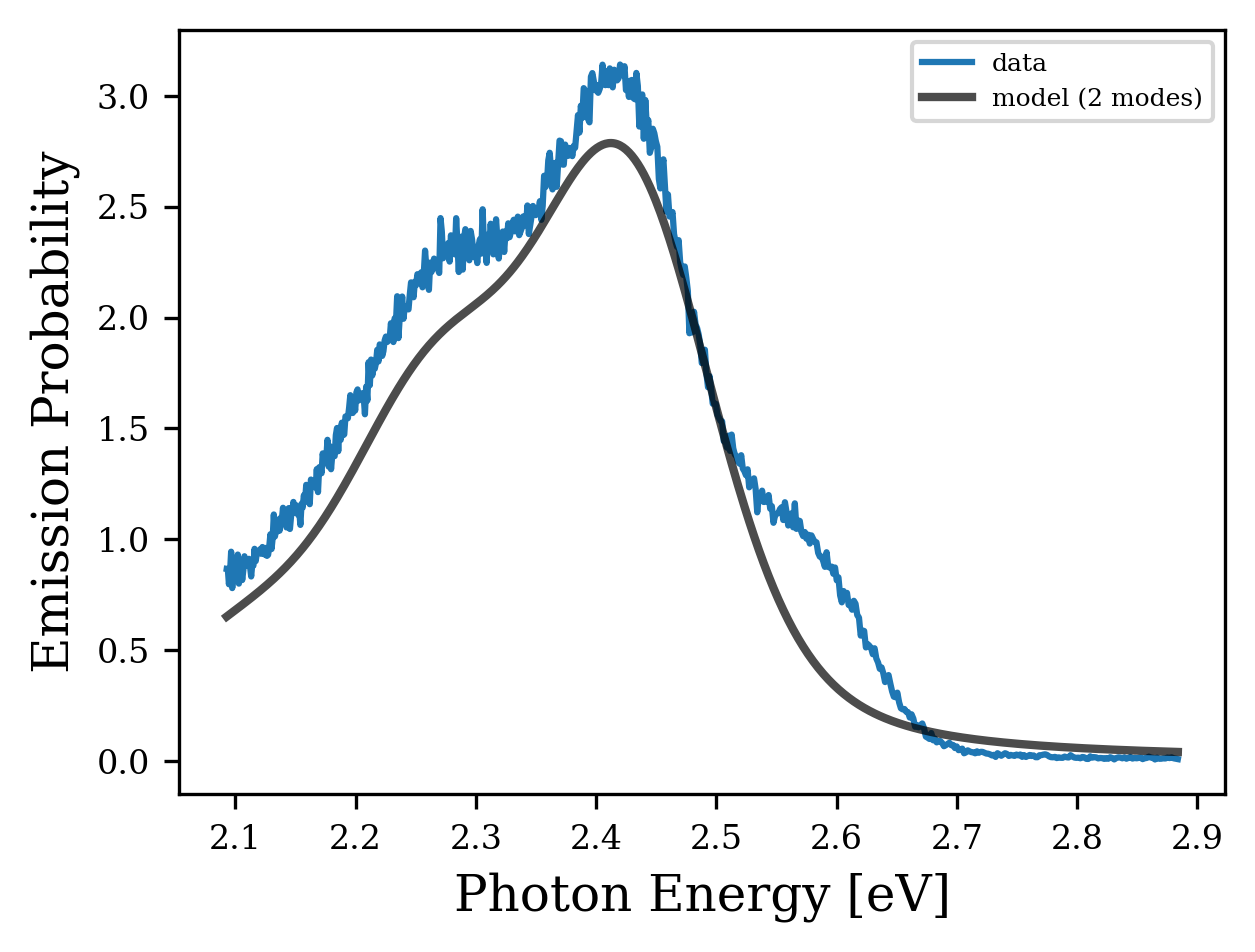

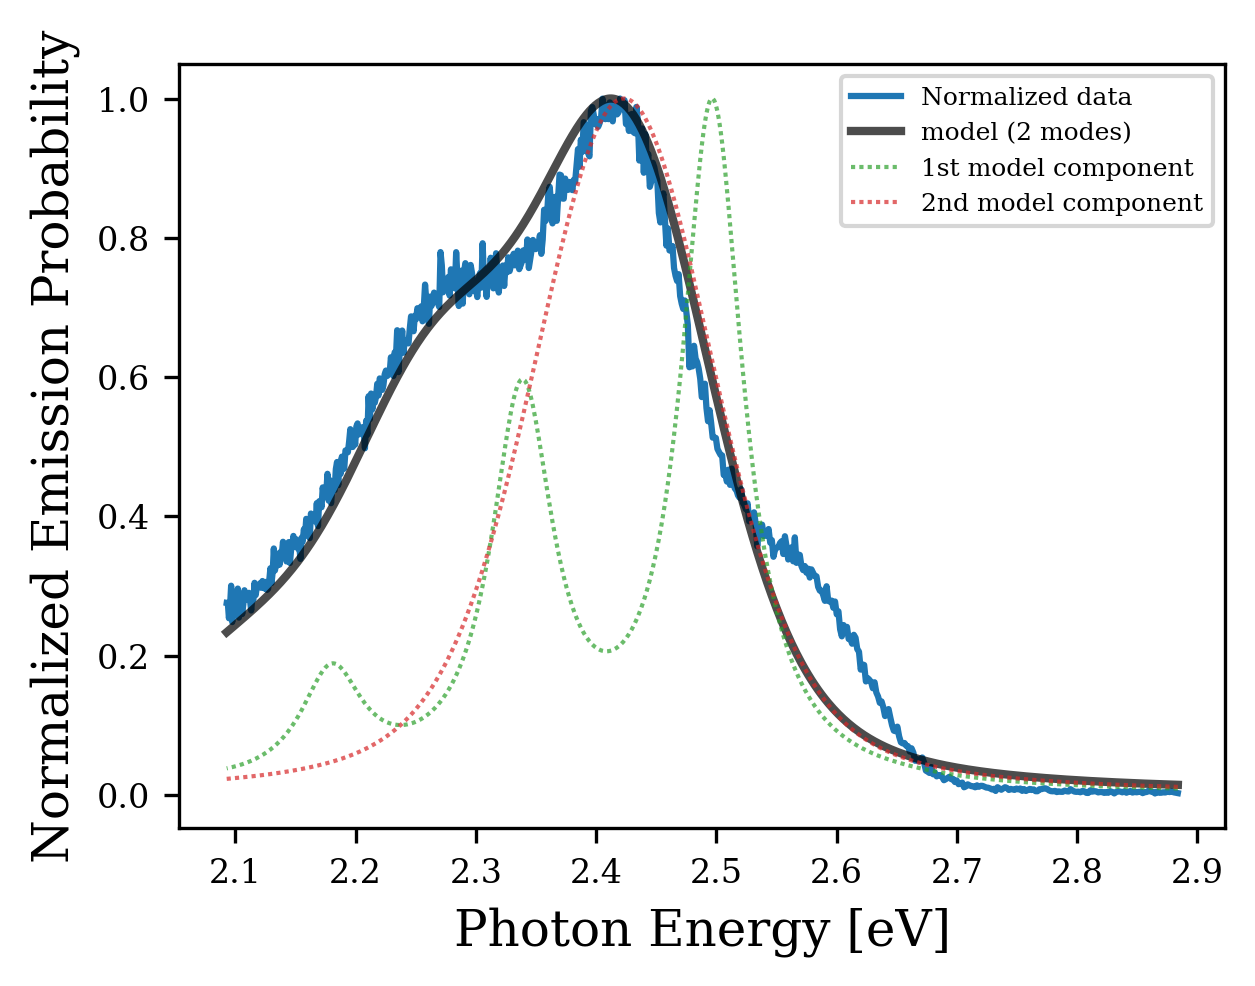

In [13]:
## Build model fit from fit parameters
model_fit_inst = model_from_params(model_fit['x'], num_modes=2, temp=T)

## Get model lineshape
model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

##
model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)


## Build first plot
plt.figure()

## Plot data and model fit
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], int_norm(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Emission Probability')

## second figure with components
plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


In [14]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

In [15]:
print_parameters_w_names(model_fit['x'])

hbar_omega_eg_0 = 2.496650466637278
hbar_gamma = 0.031403552723965486
hbar_omega_0 = [0.15821343 0.00030109]
script_d = [ 1.06328199 22.10569983]


In [10]:
fit_spectra = np.asarray([ emily_data.T[0], emily_data.T[1], model_2_mode])
np.savetxt("slow_H_fit", fit_spectra, delimiter=',')

In [62]:
#residual sum of squares
ss_res= np.sum((emily_data.T[1]- model_2_mode)**2)

#total sum of squares
ss_tot = np.sum((emily_data.T[1]- np.mean(emily_data.T[1]))**2)

#r-squared
r2 = 1- (ss_res/ss_tot)

print(ss_res, r2)

27.81436085221588 0.9649867269541492
